# MediaPipe Human-Centric Vision Tasks Demo

This notebook demonstrates each of Sapiens' vision tasks using your video input.

## Setup and Imports

In [43]:
# Import required libraries
!pip install mediapipe
import cv2

import mediapipe as mp

import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path

from IPython.display import Image, display

from typing import List, Dict, Optional, Tuple

import math

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [44]:
# Initialize MediaPipe solutions

mp_face_detection = mp.solutions.face_detection

mp_face_mesh = mp.solutions.face_mesh

mp_pose = mp.solutions.pose

mp_drawing = mp.solutions.drawing_utils

mp_drawing_styles = mp.solutions.drawing_styles

In [45]:
def load_video_frame(video_path: str, frame_number: int = 0) -> np.ndarray:

    """Load a specific frame from video"""

    cap = cv2.VideoCapture(video_path)

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    ret, frame = cap.read()

    cap.release()

    if not ret:

        raise ValueError("Could not read frame")

    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)



def display_results(original, processed, title="Results"):

    """Display original and processed images side by side"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.imshow(original)

    ax1.set_title("Original")

    ax1.axis('off')

    

    ax2.imshow(processed)

    ax2.set_title("Processed")

    ax2.axis('off')

    

    plt.suptitle(title)

    plt.show()



def detect_faces(image):

    """Detect faces in image using MediaPipe Face Detection"""

    with mp_face_detection.FaceDetection(

        model_selection=1, min_detection_confidence=0.5) as face_detection:

        results = face_detection.process(image)

        

        # Draw detections

        annotated_image = image.copy()

        if results.detections:

            for detection in results.detections:

                mp_drawing.draw_detection(annotated_image, detection)

        

        return results.detections, annotated_image



# 2. Face Mesh

def get_face_mesh(image):

    """Get detailed face mesh using MediaPipe Face Mesh"""

    with mp_face_mesh.FaceMesh(

        static_image_mode=True,

        max_num_faces=1,

        refine_landmarks=True,

        min_detection_confidence=0.5) as face_mesh:

        results = face_mesh.process(image)

        

        # Draw face mesh

        annotated_image = image.copy()

        if results.multi_face_landmarks:

            for face_landmarks in results.multi_face_landmarks:

                mp_drawing.draw_landmarks(

                    image=annotated_image,

                    landmark_list=face_landmarks,

                    connections=mp_face_mesh.FACEMESH_TESSELATION,

                    landmark_drawing_spec=None,

                    connection_drawing_spec=mp_drawing_styles

                    .get_default_face_mesh_tesselation_style())

                

        return results.multi_face_landmarks, annotated_image



# 3. Pose Detection

def detect_pose(image):

    """Detect body pose using MediaPipe Pose"""

    with mp_pose.Pose(

        static_image_mode=True,

        model_complexity=2,

        min_detection_confidence=0.5) as pose:

        results = pose.process(image)

        

        # Draw pose landmarks

        annotated_image = image.copy()

        if results.pose_landmarks:

            mp_drawing.draw_landmarks(

                annotated_image,

                results.pose_landmarks,

                mp_pose.POSE_CONNECTIONS,

                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

            

        return results.pose_landmarks, annotated_image

def get_face_mesh_coords(landmarks, image_shape):
    """Convert MediaPipe face mesh landmarks to image coordinates"""
    image_height, image_width = image_shape[:2]
    coords = []
    # These indices correspond to the specific facial landmarks we need
    indices = [1, 152, 33, 263, 61, 291]  # Nose tip, Chin, Left eye, Right eye, Left mouth, Right mouth
    for idx in indices:
        landmark = landmarks.landmark[idx]
        x = int(landmark.x * image_width)
        y = int(landmark.y * image_height)
        coords.append([x, y])
    return np.array(coords, dtype=np.float32)

In [46]:
# def calculate_yaw_angle(rotation_vector, translation_vector):
#     """
#     Calculate the yaw angle of the face using the 3D head pose estimation.
#     Returns angle in degrees, where 0 is facing forward,
#     negative is facing left, positive is facing right.
#     """
#     rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
#     proj_matrix = np.hstack((rvec_matrix, translation_vector))
#     eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6]
#     pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]
#     pitch = math.degrees(math.asin(math.sin(pitch)))
#     roll = -math.degrees(math.asin(math.sin(roll)))
#     yaw = math.degrees(math.asin(math.sin(yaw)))
#     return yaw

In [47]:
def calculate_yaw_pitch_roll(rotation_vector, translation_vector):
    """
    Calculate the yaw, pitch, and roll angles of the face using the 3D head pose estimation.
    Returns angles in degrees.
    """
    rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
    proj_matrix = np.hstack((rvec_matrix, translation_vector))
    eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6]
    pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]
    pitch = math.degrees(math.asin(math.sin(pitch)))
    roll = -math.degrees(math.asin(math.sin(roll)))
    yaw = math.degrees(math.asin(math.sin(yaw)))
    return yaw, pitch, roll

def detect_faces_with_3d_pose(image: np.ndarray) -> Tuple[List[Dict], np.ndarray]:
    """Detect faces in image and calculate 3D head pose using OpenCV"""
    face_data = []
    annotated_image = image.copy()
    # Load the 3D model points for face landmarks
    model_points = np.array([
        (0.0, 0.0, 0.0),  # Nose tip
        (0.0, -330.0, -65.0),  # Chin
        (-225.0, 170.0, -135.0),  # Left eye left corner
        (225.0, 170.0, -135.0),  # Right eye right corner
        (-150.0, -150.0, -125.0),  # Left Mouth corner
        (150.0, -150.0, -125.0)  # Right mouth corner
    ])
    # Define the camera matrix and distortion coefficients
    camera_matrix = np.array([[900, 0, 320], [0, 900, 240], [0, 0, 1]], dtype="double")
    dist_coeffs = np.array([0.0, 0.0, 0.0, 0.0])
    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5) as face_mesh:
        
        results = face_mesh.process(image)
        
        if results.multi_face_landmarks:
            for idx, face_landmarks in enumerate(results.multi_face_landmarks):
                # Calculate 2D facial landmarks
                image_points = get_face_mesh_coords(face_landmarks, image.shape)
                success, rotation_vector, translation_vector = cv2.solvePnP(
                    model_points, image_points, camera_matrix, dist_coeffs)
                if not success:
                    continue
                # Calculate 3D head pose
                img_pts, _ = cv2.projectPoints(model_points, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
                # Calculate yaw, pitch, and roll angles
                yaw_angle, pitch_angle, roll_angle = calculate_yaw_pitch_roll(rotation_vector, translation_vector)
                # Draw face mesh
                mp_drawing.draw_landmarks(
                    image=annotated_image,
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style())
                # Add yaw angle text to image
                h, w = image.shape[:2]
                cv2.putText(
                    annotated_image,
                    f"Yaw: {yaw_angle:.1f}°",
                    (int(w * 0.05), int(h * 0.95)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (255, 255, 255),
                    2
                )
                face_data.append({
                    'yaw_angle': yaw_angle,
                    'pitch_angle': pitch_angle,
                    'roll_angle': roll_angle,
                    'landmarks': face_landmarks
                })
    return face_data, annotated_image

In [48]:
def trim_videos(input_folder: str, output_folder: str, log_file: str) -> Dict[str, List[str]]:

    """

    Trim input videos based on face detection and continuous detection.

    Returns a dictionary with the following keys:

        - 'input_videos': List of input video paths

        - 'trimmed_videos': List of trimmed video paths

        - 'final_clips': List of final clip paths after sliding window

        - 'deletion_rate': Percentage of original video duration that was removed

        - 'deletion_reasons': Reasons for removal (e.g., no face, small face)

    """

    input_video_paths = [str(p) for p in Path(input_folder).glob('*.mp4')]

    trimmed_video_paths = []

    final_clips = []

    total_original_duration = 0

    total_trimmed_duration = 0

    deletion_reasons = {}

    failed_frames_folder = os.path.join(output_folder, 'failed_frames')

    os.makedirs(failed_frames_folder, exist_ok=True)



    print(f"Input Videos: {len(input_video_paths)}", file=open(log_file, 'a'))





    for input_video_path in input_video_paths:

        cap = cv2.VideoCapture(input_video_path)

        fps = cap.get(cv2.CAP_PROP_FPS)

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        total_original_duration += frame_count / fps



        # Trim the video

        start_frame, end_frame, failed_frames = trim_video(cap, fps, failed_frames_folder)

        if start_frame is not None and end_frame is not None:

            trimmed_duration = (end_frame - start_frame) / fps

            total_trimmed_duration += trimmed_duration



            trimmed_video_path = os.path.join(output_folder, os.path.basename(input_video_path))

            write_trimmed_video(cap, trimmed_video_path, start_frame, end_frame)

            trimmed_video_paths.append(trimmed_video_path)



            # Split the trimmed video into sliding windows

            split_into_windows(trimmed_video_path, output_folder, fps)

            final_clips.extend([os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.mp4')])

        else:

            deletion_reasons[input_video_path] = "No face detected or face too small"



        cap.release()



    deletion_rate = 1 - (total_trimmed_duration / total_original_duration) * 100



    print(f"Trimmed Videos: {len(trimmed_video_paths)}", file=open(log_file, 'a'))

    print(f"Final Clips: {len(final_clips)}", file=open(log_file, 'a'))

    print(f"Deletion Rate: {deletion_rate:.2f}%", file=open(log_file, 'a'))

    print("Deletion Reasons:", file=open(log_file, 'a'))

    for video, reason in deletion_reasons.items():

        print(f"{video}: {reason}", file=open(log_file, 'a'))



    return {

        'input_videos': input_video_paths,

        'trimmed_videos': trimmed_video_paths,

        'final_clips': final_clips,

        'deletion_rate': deletion_rate,

        'deletion_reasons': deletion_reasons

    }


def detect_faces_with_yaw(image: np.ndarray) -> Tuple[List[Dict], np.ndarray]:
    return detect_faces_with_3d_pose(image)


In [49]:
def trim_video(cap: cv2.VideoCapture, fps: float, failed_frames_folder: str) -> Tuple[Optional[int], Optional[int], List[int]]:

    """

    Trim the video based on face detection and continuous detection, and yaw angle.

    Returns the start and end frame indices for the trimmed video.

    """

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    start_frame = None

    end_frame = None

    failed_frames = []



    # Parameters for yaw angle filtering

    MAX_YAW_ANGLE = 30 # Maximum allowed yaw angle in degrees



    valid_frames = 0

    for frame_idx in range(frame_count):

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        ret, frame = cap.read()

        if not ret:

            break



        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        face_data, _ = detect_faces_with_yaw(frame_rgb)



        if face_data:

            yaw_angle = abs(face_data[0]['yaw_angle'])



            #check if face is within acceptable yaw angle

            if yaw_angle <= MAX_YAW_ANGLE:

                valid_frames += 1

                if start_frame is None:

                    start_frame = max(0, frame_idx - int(5 * fps))



    # with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:

    #     valid_frames = 0

    #     for frame_idx in range(frame_count):

    #         cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

    #         ret, frame = cap.read()

    #         if not ret:

    #             break

    #         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)



    #         results = face_detection.process(frame)

    #         if results.detections:

    #             for detection in results.detections:

    #                 if min(detection.location_data.relative_bounding_box.width, detection.location_data.relative_bounding_box.height) >= 0.25:

    #                     valid_frames += 1

    #                     if start_frame is None:

    #                         start_frame = max(0, frame_idx - int(5 * fps))

                    

                else:

                    valid_frames = 0

                    if start_frame is not None:

                        end_frame = frame_idx

                        failed_frames.append(frame_idx)

                        cv2.imwrite(

                            os.path.join(failed_frames_folder, f"frame_{frame_idx}.jpg"), 

                            cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

                        return start_frame, end_frame, failed_frames

            else:

                valid_frames = 0

                if start_frame is not None:

                    end_frame = frame_idx

                    failed_frames.append(frame_idx)

                    cv2.imwrite(

                        os.path.join(failed_frames_folder, f"frame_{frame_idx}.jpg"),

                        cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

                        )

                    return start_frame, end_frame, failed_frames



    return None, None, failed_frames             

In [50]:
def write_trimmed_video(cap: cv2.VideoCapture, output_path: str, start_frame: int, end_frame: int):

    """Write the trimmed video to the output path"""

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')

    fps = cap.get(cv2.CAP_PROP_FPS)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))

    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))



    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    for frame_idx in range(start_frame, end_frame):

        ret, frame = cap.read()

        if not ret:

            break

        out.write(frame)



    out.release()

In [51]:
def split_into_windows(input_video_path: str, output_folder: str, fps: float):

    """

    Split the trimmed video into sliding windows.

    The window size is 10 seconds, and the shift width is 3 seconds.

    """

    window_size = int(10 * fps)

    shift_width = int(3 * fps)



    cap = cv2.VideoCapture(input_video_path)

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    duration = frame_count / fps



    start_frame = 0

    while start_frame < frame_count:

        end_frame = min(start_frame + window_size, frame_count)

        clip_name = f"clip_{start_frame//shift_width}.mp4"

        clip_path = os.path.join(output_folder, clip_name)

        write_trimmed_video(cap, clip_path, start_frame, end_frame)

        start_frame += shift_width



    cap.release()

In [52]:
# video_path = "../data/inputs/堀江貴文 動画.mp4"

# frame = load_video_frame(video_path)

import os 

# Example usage

input_folder = "/kaggle/input/videos/852399-hd_1280_720_24fps.mp4"

output_folder = "kaggle/working/data/outputs/videos"

log_file = "kaggle/working/data/outputs/video_processing_log.txt"

os.makedirs(output_folder, exist_ok=True)





frame = load_video_frame(input_folder)




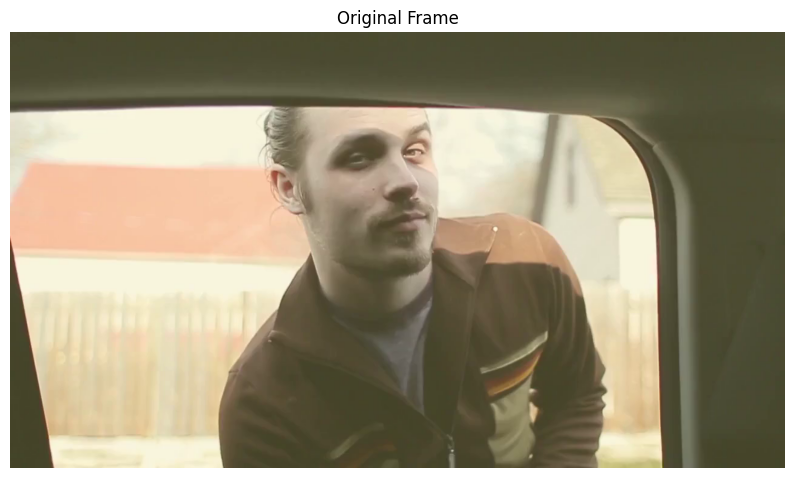

In [53]:
plt.figure(figsize=(10, 8))

plt.imshow(frame)

plt.title("Original Frame")

plt.axis('off')

plt.show()

W0000 00:00:1731051869.489183    3467 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


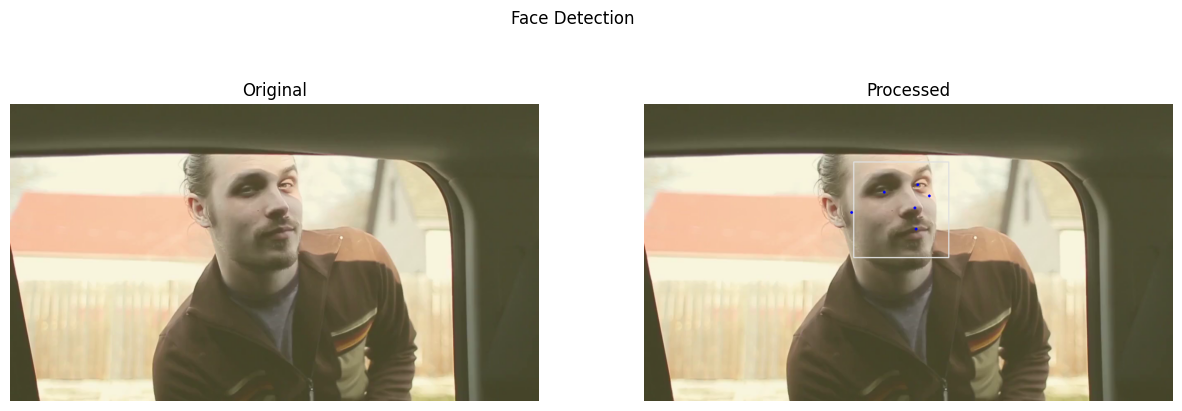

Face Detection Results:
Face 1 confidence: 0.82


In [54]:
# 1. Face Detection Analysis

face_detections, face_image = detect_faces(frame)

display_results(frame, face_image, "Face Detection")



if face_detections:

    print("Face Detection Results:")

    for idx, detection in enumerate(face_detections):

        print(f"Face {idx+1} confidence: {detection.score[0]:.2f}")

W0000 00:00:1731051870.075633    3473 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051870.093953    3472 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


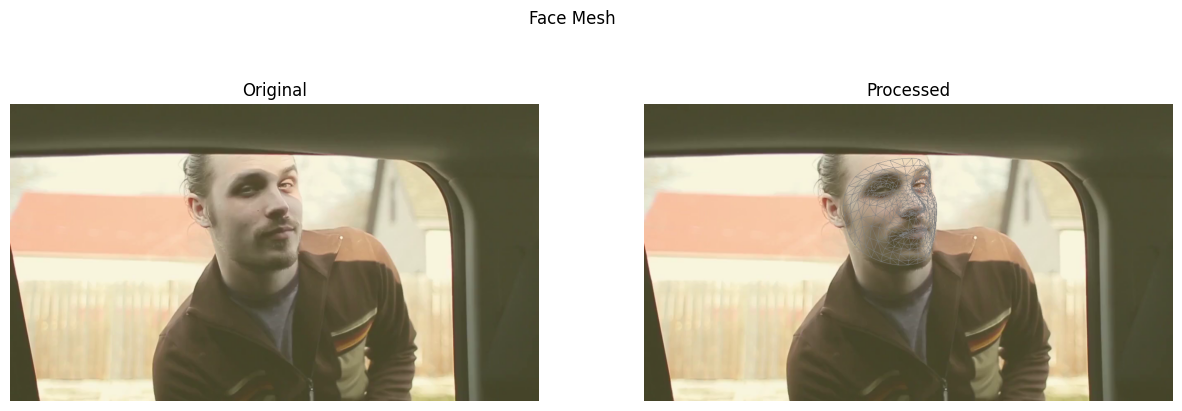


Face Mesh Results:
Number of landmark points: 478


In [55]:
# 2. Face Mesh Analysis

face_landmarks, mesh_image = get_face_mesh(frame)

display_results(frame, mesh_image, "Face Mesh")



if face_landmarks:

    print("\nFace Mesh Results:")

    print(f"Number of landmark points: {len(face_landmarks[0].landmark)}")

W0000 00:00:1731051870.807363    3476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051870.943747    3476 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


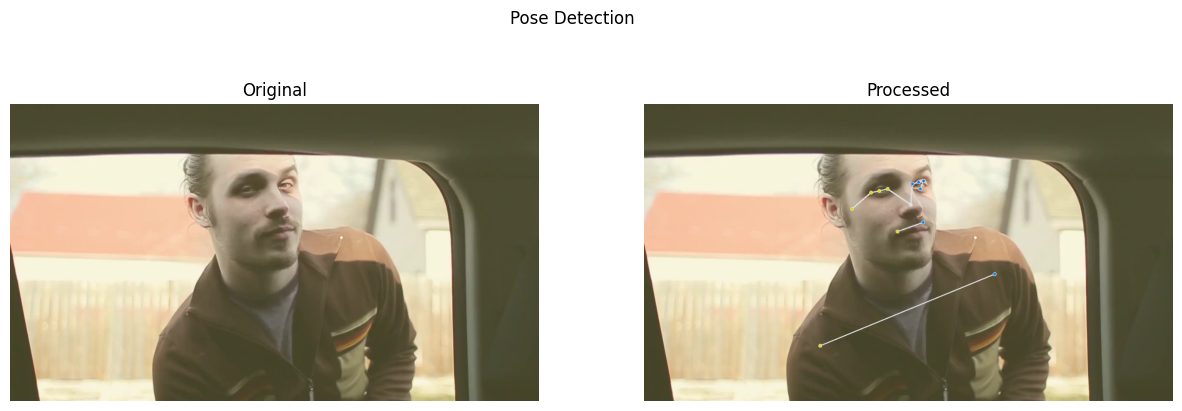


Pose Detection Results:
Normalized shoulder width: 0.41
Head position (normalized): x=0.50, y=0.34


In [56]:
# 3. Pose Analysis

pose_landmarks, pose_image = detect_pose(frame)

display_results(frame, pose_image, "Pose Detection")



if pose_landmarks:

    print("\nPose Detection Results:")

    # Calculate some basic pose metrics

    nose = pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE]

    left_shoulder = pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]

    right_shoulder = pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]

    

    # Calculate shoulder width (normalized)

    shoulder_width = np.sqrt((left_shoulder.x - right_shoulder.x)**2 + 

                           (left_shoulder.y - right_shoulder.y)**2)

    print(f"Normalized shoulder width: {shoulder_width:.2f}")

    print(f"Head position (normalized): x={nose.x:.2f}, y={nose.y:.2f}")


W0000 00:00:1731051871.672241    3480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051871.693626    3484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051871.703481    3485 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051871.835607    3488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051871.970664    3488 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


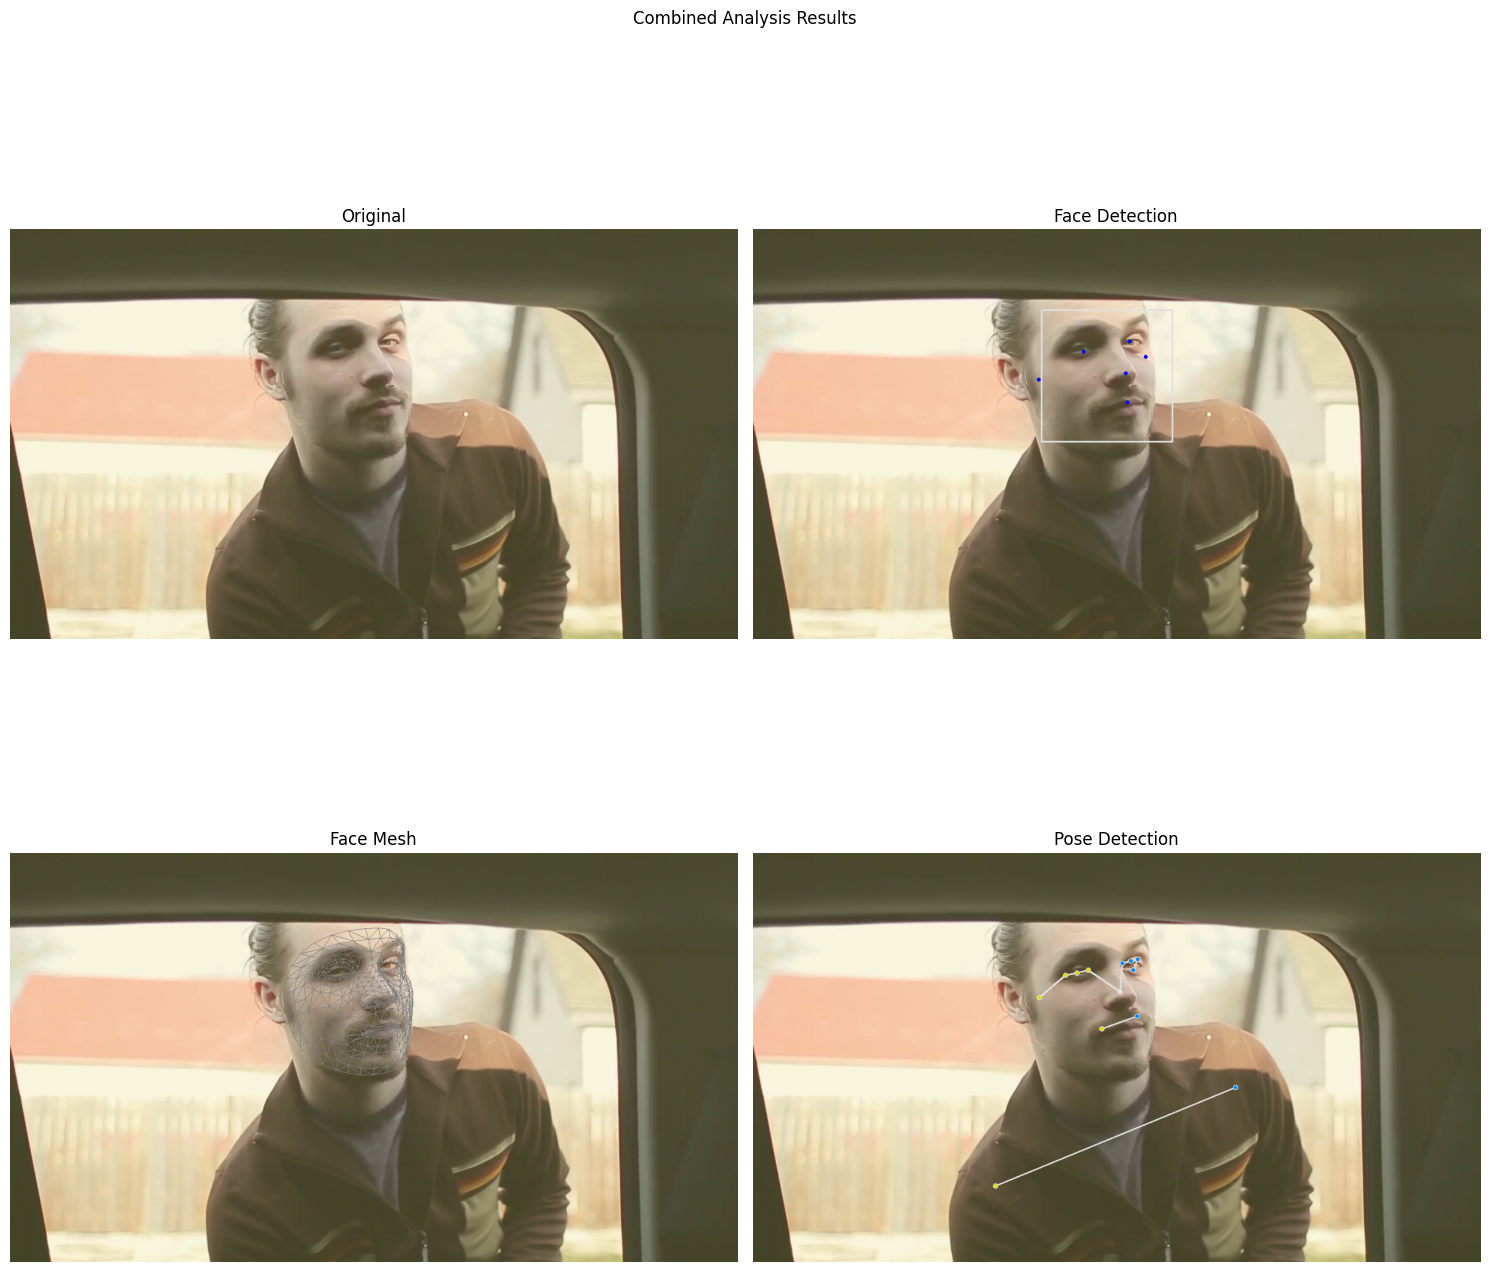

In [57]:
# Combined Analysis

def analyze_frame(frame):

    """Perform combined analysis of the frame"""

    # Create a figure with subplots

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    fig.suptitle("Combined Analysis Results")

    

    # Original

    axes[0, 0].imshow(frame)

    axes[0, 0].set_title("Original")

    axes[0, 0].axis('off')

    

    # Face Detection

    _, face_image = detect_faces(frame)

    axes[0, 1].imshow(face_image)

    axes[0, 1].set_title("Face Detection")

    axes[0, 1].axis('off')

    

    # Face Mesh

    _, mesh_image = get_face_mesh(frame)

    axes[1, 0].imshow(mesh_image)

    axes[1, 0].set_title("Face Mesh")

    axes[1, 0].axis('off')

    

    # Pose Detection

    _, pose_image = detect_pose(frame)

    axes[1, 1].imshow(pose_image)

    axes[1, 1].set_title("Pose Detection")

    axes[1, 1].axis('off')

    

    plt.tight_layout()

    plt.show()



# Perform combined analysis

analyze_frame(frame)

In [58]:
# Quality Metrics

def calculate_quality_metrics(frame):

    """Calculate quality metrics for the frame"""

    metrics = {}

    

    # Face detection metrics

    # face_detections, _ = detect_faces(frame)

    # metrics['face_detected'] = bool(face_detections)

    # if face_detections:

    #     metrics['face_confidence'] = face_detections[0].score[0]

    # Face detection metrics with 3D pose
    face_data, _ = detect_faces_with_3d_pose(frame)
    metrics['face_detected'] = bool(face_data)

    if face_data:
        metrics['yaw_angle'] = face_data[0]['yaw_angle']
        metrics['pitch_angle'] = face_data[0]['pitch_angle']
        metrics['roll_angle'] = face_data[0]['roll_angle']
    
    # Pose metrics
    pose_landmarks, _ = detect_pose(frame)
    if pose_landmarks:
        # Calculate pose metrics
        nose = pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE]
        left_shoulder = pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
        right_shoulder = pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
        
        metrics['shoulder_width'] = np.sqrt((left_shoulder.x - right_shoulder.x)**2 + 
                                          (left_shoulder.y - right_shoulder.y)**2)
        metrics['head_position_x'] = nose.x
        metrics['head_position_y'] = nose.y
    
    return metrics



# Calculate and display metrics

metrics = calculate_quality_metrics(frame)

print("\nQuality Metrics:")

for metric, value in metrics.items():

    print(f"{metric}: {value:.3f}" if isinstance(value, float) else f"{metric}: {value}")

W0000 00:00:1731051873.138647    3491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051873.151495    3492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/tmp/ipykernel_31/2363622751.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]
W0000 00:00:1731051873.270036    3495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.



Quality Metrics:
face_detected: True
yaw_angle: -63.376
pitch_angle: -5.676
roll_angle: -15.393
shoulder_width: 0.408
head_position_x: 0.504
head_position_y: 0.341


W0000 00:00:1731051873.411335    3495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


W0000 00:00:1731051873.544195    3504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051873.555935    3504 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/tmp/ipykernel_31/2363622751.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]


Detected face with Yaw Angle: -63.4°


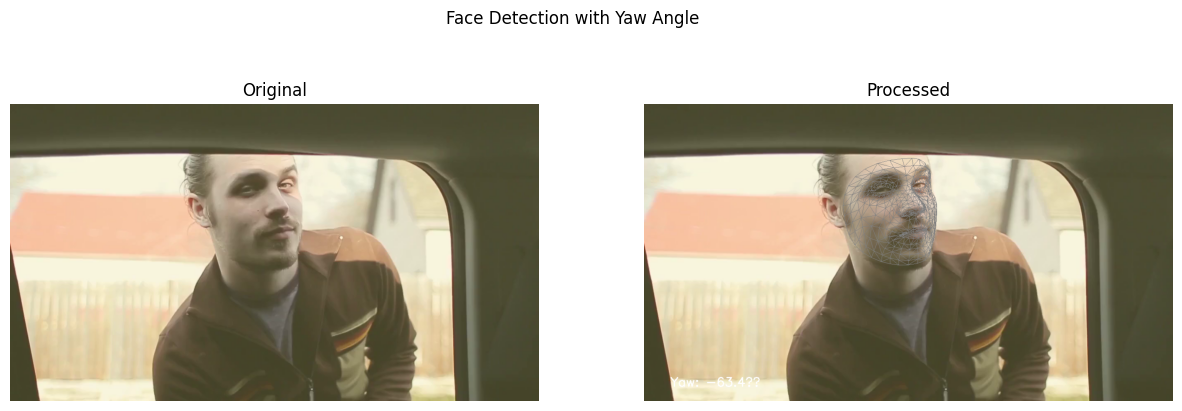

In [59]:
# example usage with yaw angle 

frame = load_video_frame(input_folder)

face_data, annotated_frame = detect_faces_with_yaw(frame)



if face_data:

    print(f"Detected face with Yaw Angle: {face_data[0]['yaw_angle']:.1f}°")

    

display_results(frame, annotated_frame, "Face Detection with Yaw Angle")

In [60]:
import os 

# Example usage

input_folder = "/kaggle/input/videos"

output_folder = "/kaggle/working/data/outputs/videos"

log_file ="/kaggle/working/data/outputs/video_processing_logs.txt"

os.makedirs(output_folder, exist_ok=True)



results = trim_videos(input_folder, output_folder, log_file)



print("Video Processing Pipeline Report:")

print(f"Input Videos: {len(results['input_videos'])}")

print(f"Trimmed Videos: {len(results['trimmed_videos'])}")

print(f"Final Clips: {len(results['final_clips'])}")

print(f"Deletion Rate: {results['deletion_rate']:.2f}%")

print("Deletion Reasons:")

for video, reason in results['deletion_reasons'].items():

    print(f"{video}: {reason}")

W0000 00:00:1731051874.316314    3512 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051874.342261    3511 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051874.450199    3516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051874.473596    3516 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051874.614537    3519 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1731051874.643189    3520 inference_feedback_manager.cc:114] Feedback manager 

Video Processing Pipeline Report:
Input Videos: 5
Trimmed Videos: 3
Final Clips: 15
Deletion Rate: -7.06%
Deletion Reasons:
/kaggle/input/videos/2795172-uhd_3840_2160_25fps.mp4: No face detected or face too small
/kaggle/input/videos/2795168-uhd_2160_3840_25fps.mp4: No face detected or face too small
